In [1]:
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
df_brl = pd.read_parquet('../data/all_comm/all_commodities_brl.parquet')

In [4]:
df_brl['unique_id'].unique()

array(['ACUCAR_SANTOS', 'ACUCAR_SP', 'ALGODAO', 'ARROZ', 'CAFE_ARABICA',
       'CAFE_ROBUSTA', 'MILHO', 'SOJA_PARANA', 'SOJA_PARANAGUA',
       'TRIGO_PARANA', 'TRIGO_RS'], dtype=object)

In [5]:
df_brl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59361 entries, 0 to 59360
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         59361 non-null  datetime64[ns]
 1   y          59361 non-null  float64       
 2   unique_id  59361 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


### BRL

In [6]:
Y_test_df_brl = df_brl.groupby('unique_id').tail(24)
remaining = df_brl.drop(Y_test_df_brl.index, axis = 0)
X_val_df_brl = remaining.groupby('unique_id').tail(12)
X_train_df_brl = remaining.drop(X_val_df_brl.index, axis=0)

In [7]:
X_train_df_brl.head()

,ds,y,unique_id
0,2020-01-02,65.40,ACUCAR_SANTOS
1,2020-01-03,66.80,ACUCAR_SANTOS
2,2020-01-06,68.92,ACUCAR_SANTOS
3,2020-01-07,68.85,ACUCAR_SANTOS
4,2020-01-08,68.32,ACUCAR_SANTOS


In [8]:
from statsforecast import StatsForecast
                
from statsforecast.models import (
    Naive,
    AutoARIMA
)

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [9]:
models = [
    Naive(),
    AutoARIMA(season_length=12)
]

In [10]:
sf = StatsForecast( 
    models=models,
    freq='ME',
)

In [11]:
forecasts_val = sf.forecast(df=X_train_df_brl, h=12, fitted=True)
forecasts_val.head(12)

/home/matt/anaconda3/envs/smp/lib/python3.12/site-packages/statsforecast/arima.py:1867: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=94
  warnings.warn(


,unique_id,ds,Naive,AutoARIMA
0,ACUCAR_SANTOS,2025-03-31,139.7,139.567849
1,ACUCAR_SANTOS,2025-04-30,139.7,139.543888
2,ACUCAR_SANTOS,2025-05-31,139.7,140.270193
3,ACUCAR_SANTOS,2025-06-30,139.7,140.495096
4,ACUCAR_SANTOS,2025-07-31,139.7,140.248058
5,ACUCAR_SANTOS,2025-08-31,139.7,140.691389
6,ACUCAR_SANTOS,2025-09-30,139.7,141.211394
7,ACUCAR_SANTOS,2025-10-31,139.7,141.026399
8,ACUCAR_SANTOS,2025-11-30,139.7,141.108579
9,ACUCAR_SANTOS,2025-12-31,139.7,141.702432


In [12]:
full_train = pd.concat([X_train_df_brl, X_val_df_brl])
forecasts_test = sf.forecast(df=full_train, h=24, fitted=True)

In [13]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head(10)

,unique_id,ds,y,Naive,AutoARIMA
0,ACUCAR_SANTOS,2020-01-02,65.40,NaN,65.334649
1,ACUCAR_SANTOS,2020-01-03,66.80,65.40,65.462796
2,ACUCAR_SANTOS,2020-01-06,68.92,66.80,66.791257
3,ACUCAR_SANTOS,2020-01-07,68.85,68.92,68.808982
4,ACUCAR_SANTOS,2020-01-08,68.32,68.85,68.881738
5,ACUCAR_SANTOS,2020-01-09,69.50,68.32,68.440523
6,ACUCAR_SANTOS,2020-01-10,71.13,69.50,69.388024
7,ACUCAR_SANTOS,2020-01-13,72.61,71.13,70.965401
8,ACUCAR_SANTOS,2020-01-14,73.88,72.61,72.625070
9,ACUCAR_SANTOS,2020-01-15,75.27,73.88,73.816245


In [14]:
metrics_df = pd.DataFrame()

for commodity in Y_test_df_brl['unique_id'].unique():
    actual = Y_test_df_brl[Y_test_df_brl['unique_id'] == commodity]['y']
    
    for model in ['Naive', 'AutoARIMA']:
        pred = forecasts_test[forecasts_test['unique_id'] == commodity][model]
        metrics = evaluate_forecasts(actual, pred)
        
        temp_df = pd.DataFrame({
            'Commodity': [commodity],
            'Model': [model],
            'MAE': [metrics['MAE']],
            'MAPE': [metrics['MAPE']],
            'MSE': [metrics['MSE']],
            'RMSE': [metrics['RMSE']],
            'R2': [metrics['R2']]
        })
        
        metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

metrics_df = metrics_df.round(4)

In [15]:
print("Métricas de Erro por Commodity e Modelo:")
metrics_df

Métricas de Erro por Commodity e Modelo:


,Commodity,Model,MAE,MAPE,MSE,RMSE,R2
0,ACUCAR_SANTOS,Naive,6.7775,0.0495,68.7448,8.2912,-1.8724
1,ACUCAR_SANTOS,AutoARIMA,8.0136,0.0585,93.2803,9.6582,-2.8976
2,ACUCAR_SP,Naive,3.9283,0.0275,18.9432,4.3524,-4.3948
3,ACUCAR_SP,AutoARIMA,4.5899,0.0322,24.7495,4.9749,-6.0484
4,ALGODAO,Naive,5.8442,0.0136,53.9384,7.3443,-0.4716
5,ALGODAO,AutoARIMA,4.3709,0.0103,26.5932,5.1569,0.2745
6,ARROZ,Naive,1.8092,0.0237,3.5726,1.8901,-10.9261
7,ARROZ,AutoARIMA,1.6611,0.0218,3.9020,1.9753,-12.0254
8,CAFE_ARABICA,Naive,91.9237,0.0371,12656.1931,112.4997,-1.1765
9,CAFE_ARABICA,AutoARIMA,167.2895,0.0670,33374.9767,182.6882,-4.7396


In [16]:
print("\nMétricas Médias por Modelo:")
print(metrics_df.groupby('Model')[['MAE', 'RMSE', 'MAPE', 'R2']].mean().round(4))


Métricas Médias por Modelo:
               MAE     RMSE    MAPE      R2
Model                                      
AutoARIMA  51.7332  56.7645  0.0453 -3.7204
Naive      42.5461  48.0532  0.0414 -3.8346


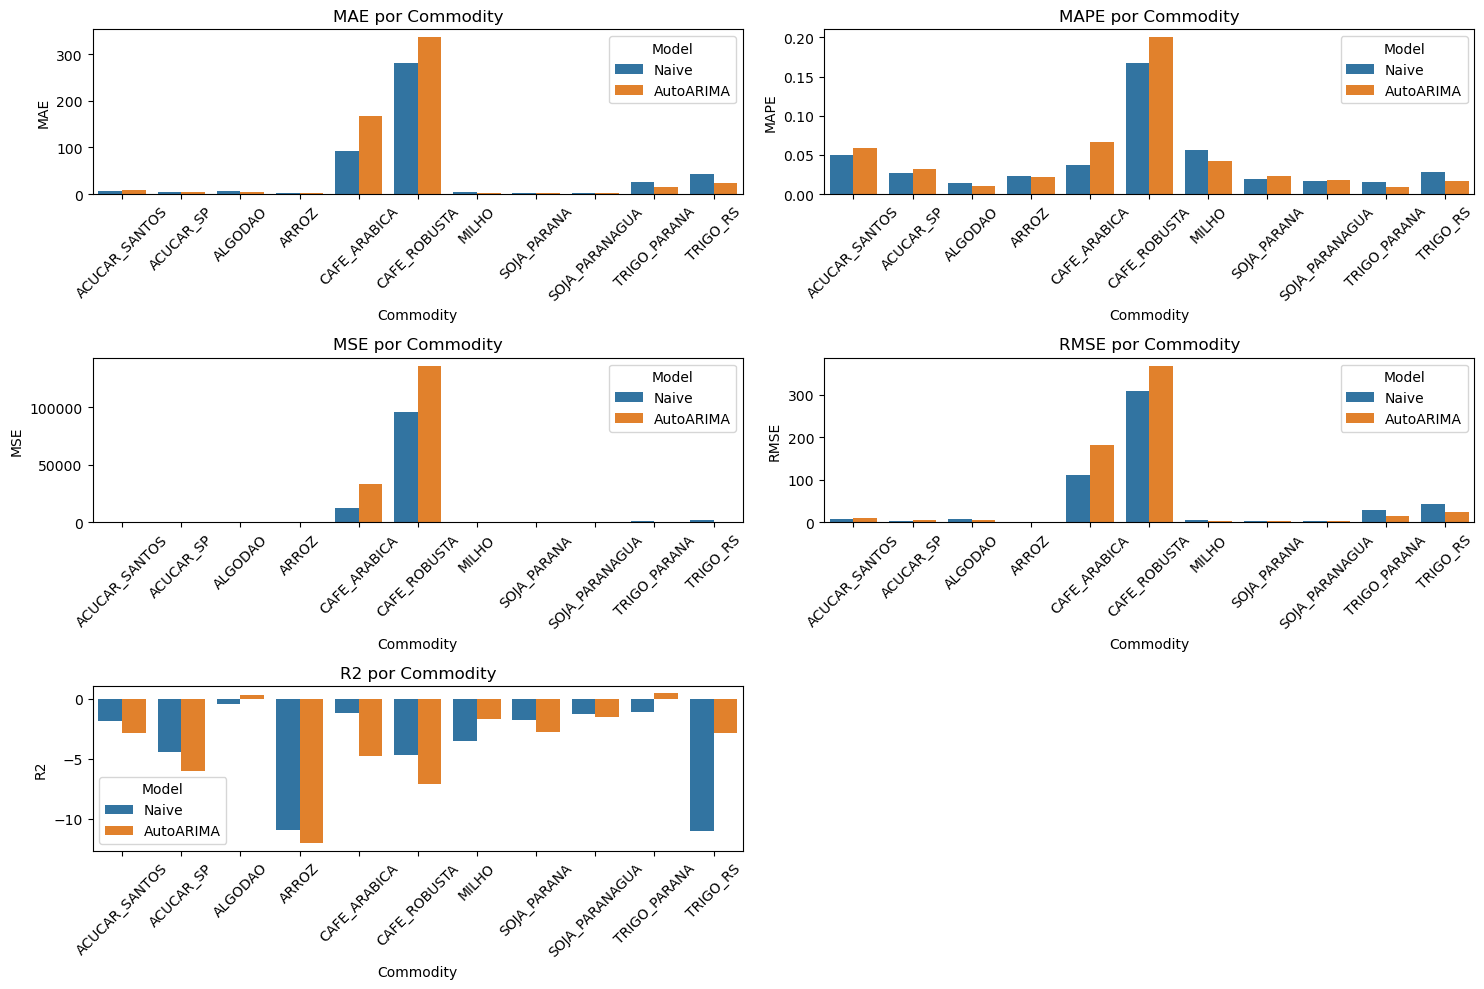

In [17]:
plot_metrics_comparison(metrics_df)

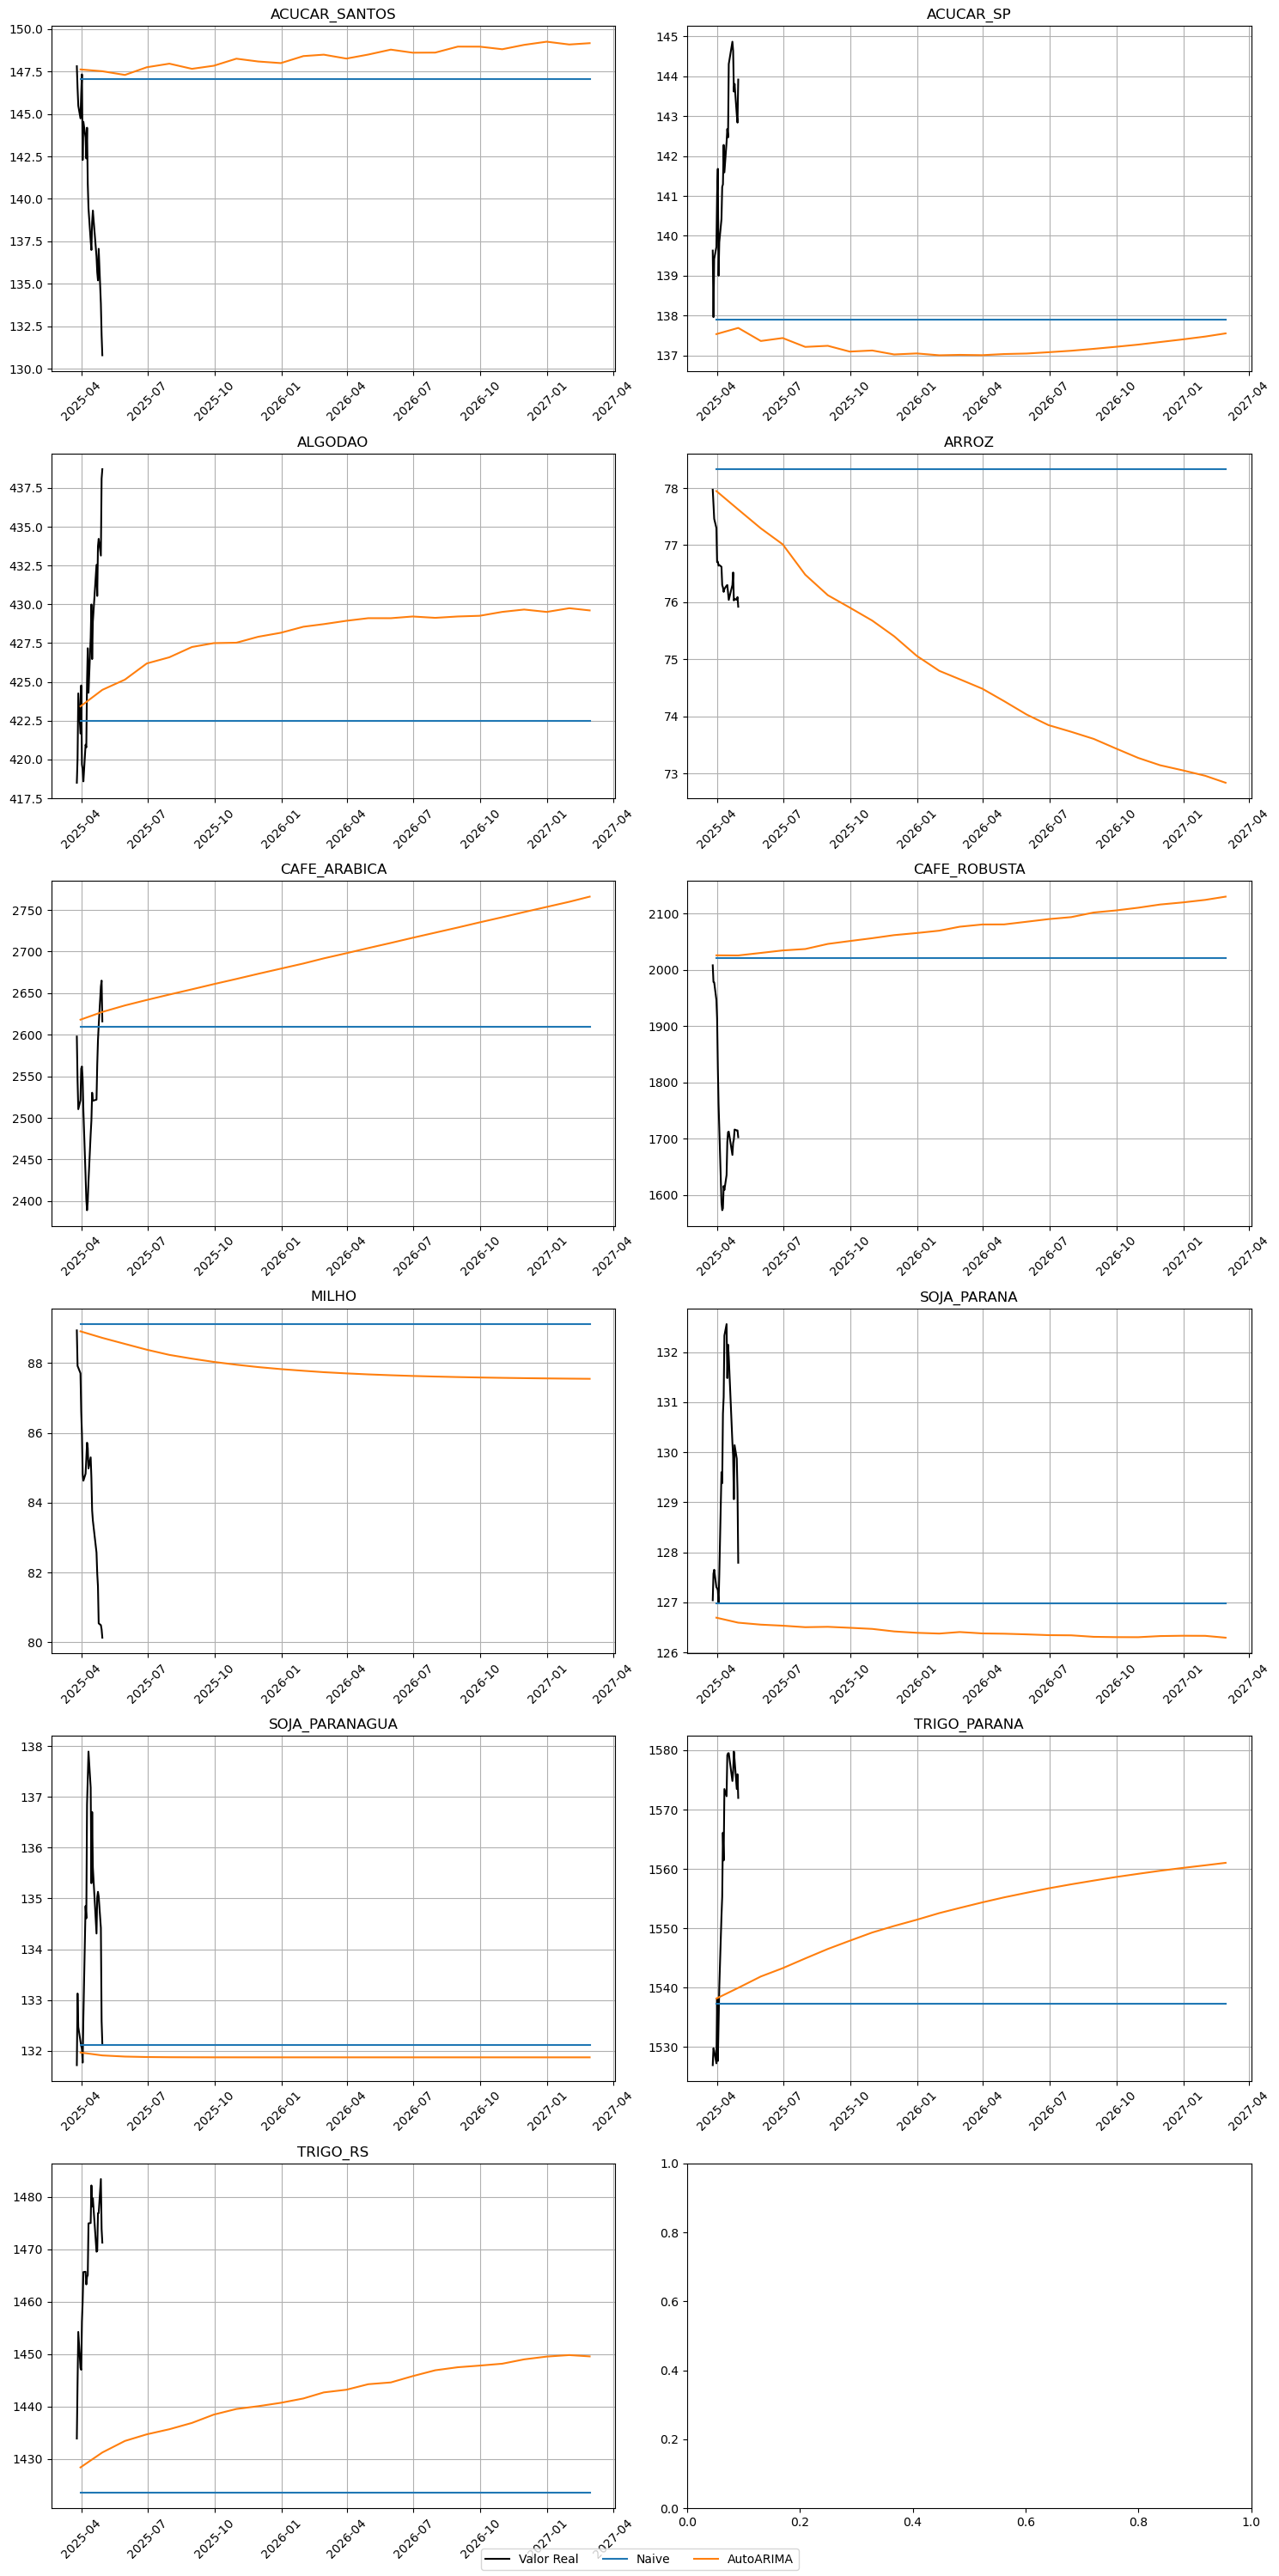

In [18]:
commodities = Y_test_df_brl['unique_id'].unique()
plot_forecasts_grid(
    actual=Y_test_df_brl,
    forecasts=forecasts_test,
    models=['Naive', 'AutoARIMA'],
    commodities=commodities
)

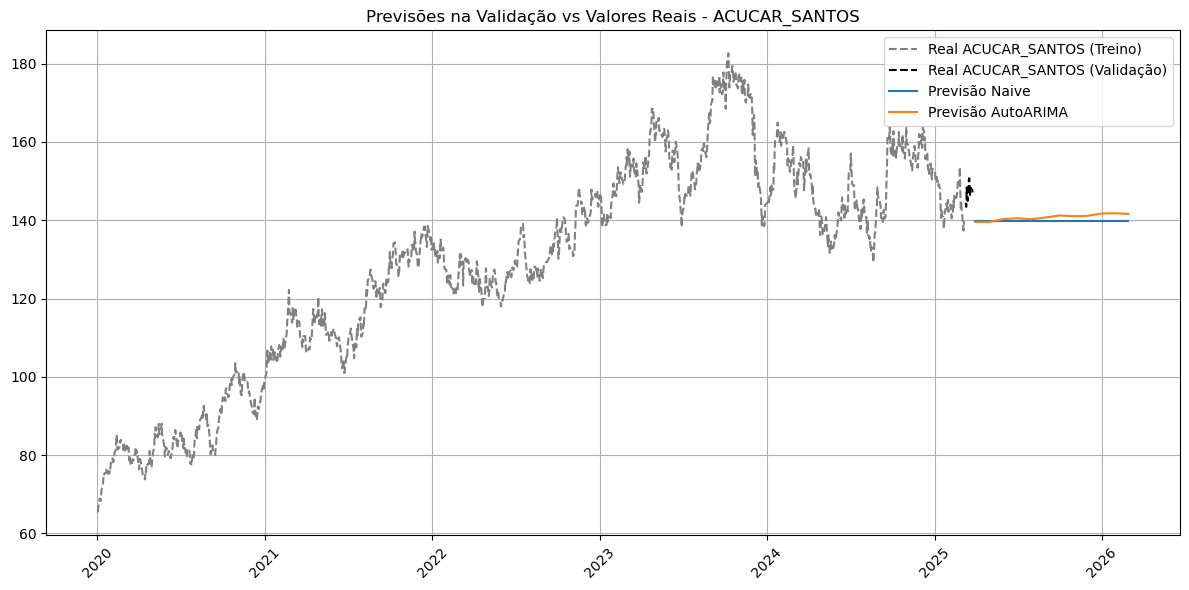

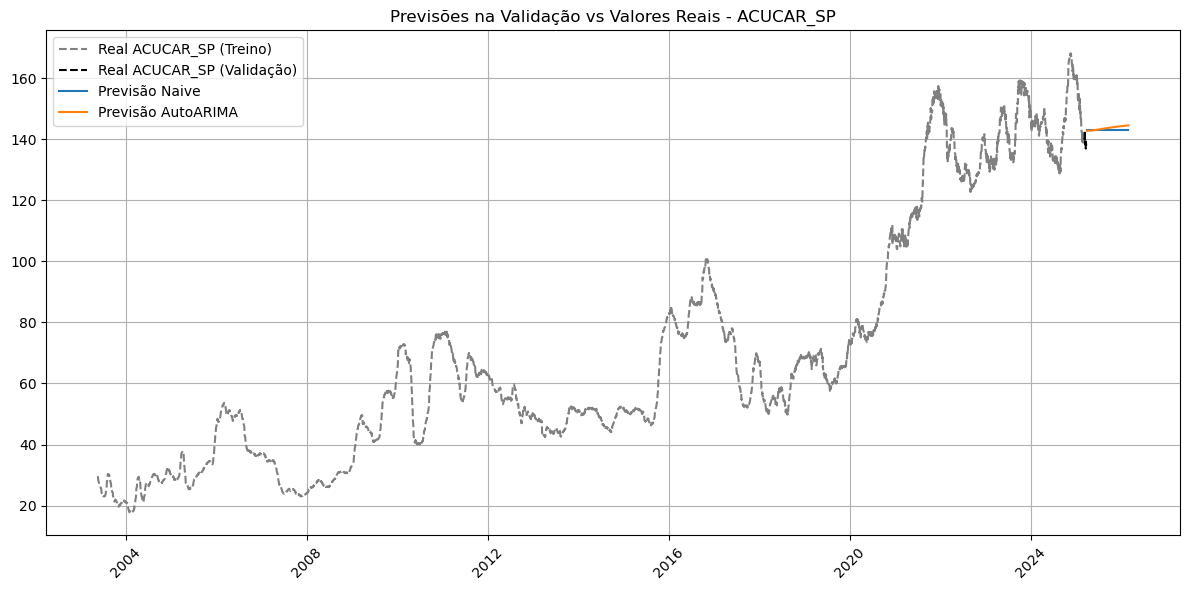

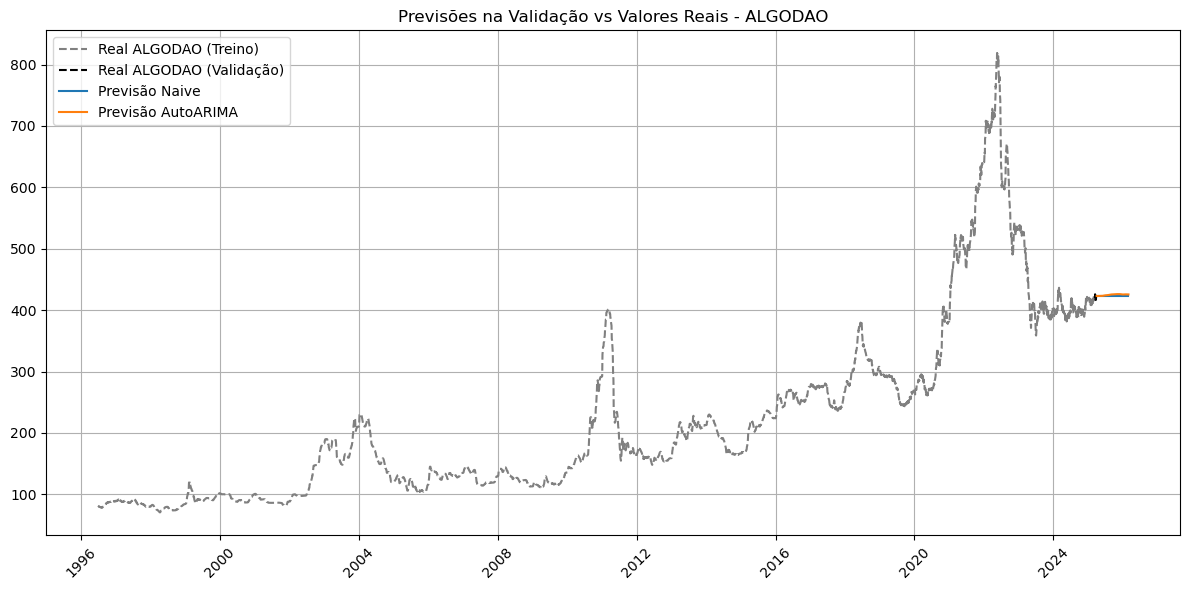

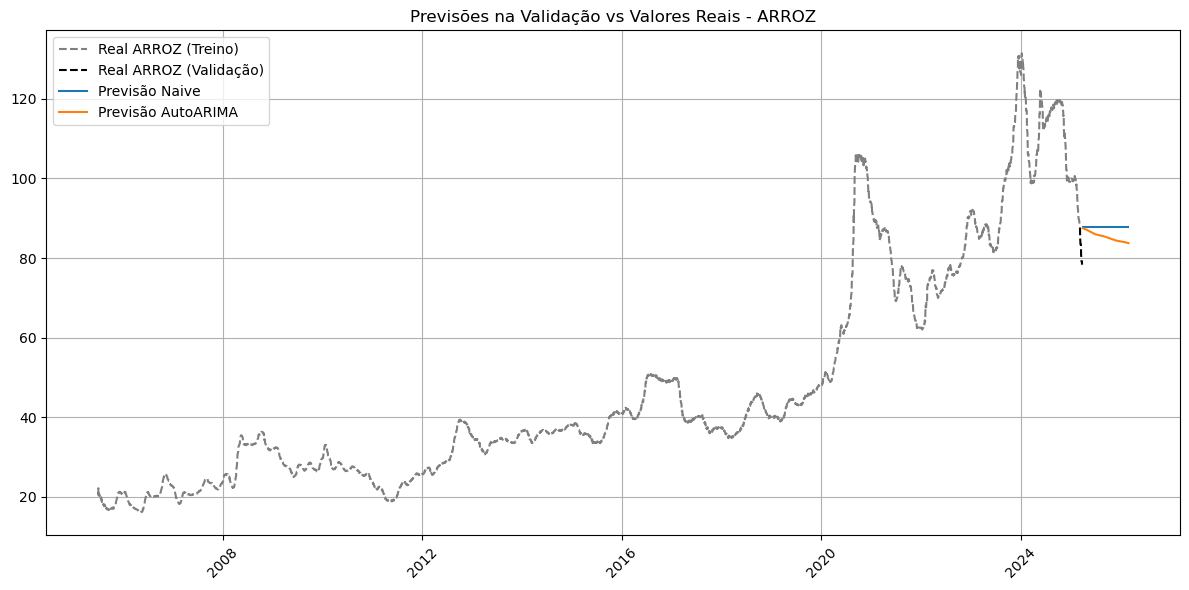

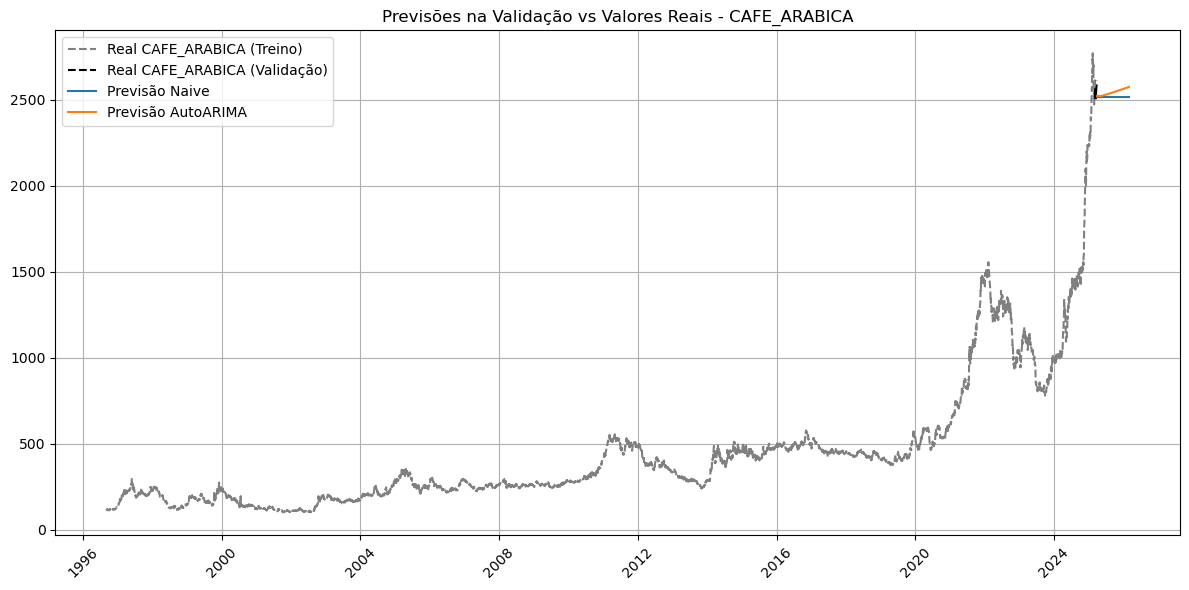

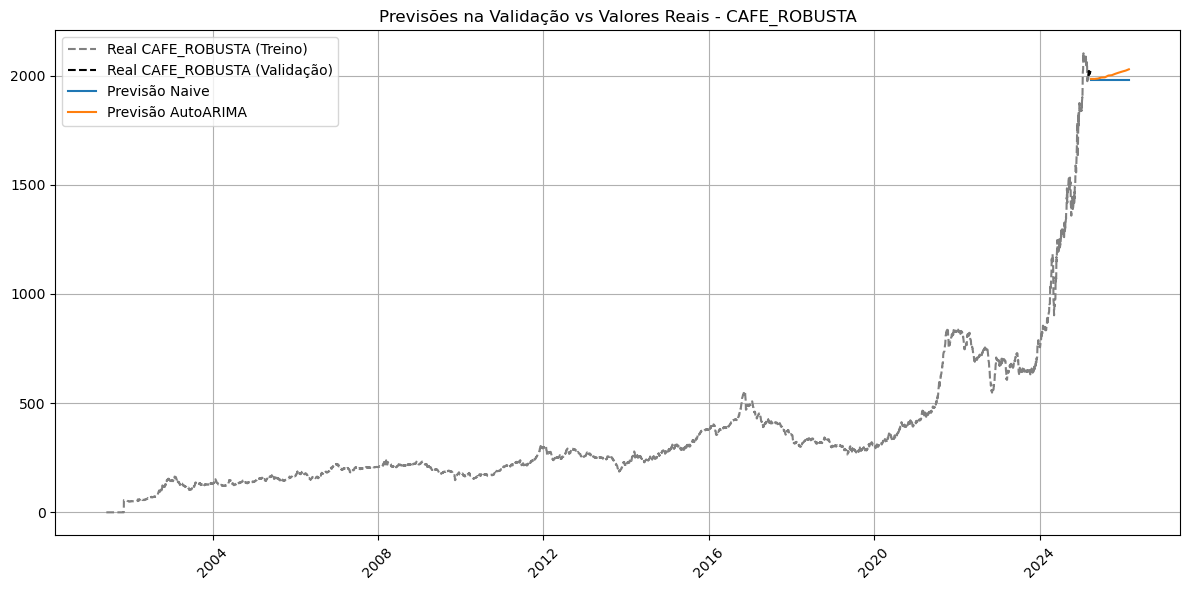

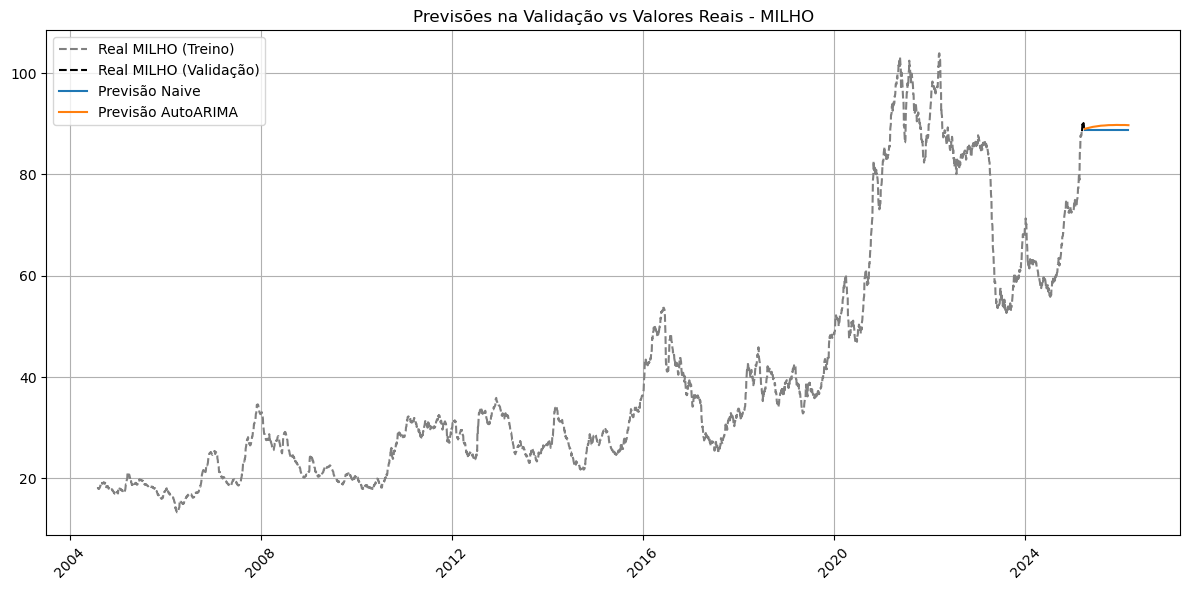

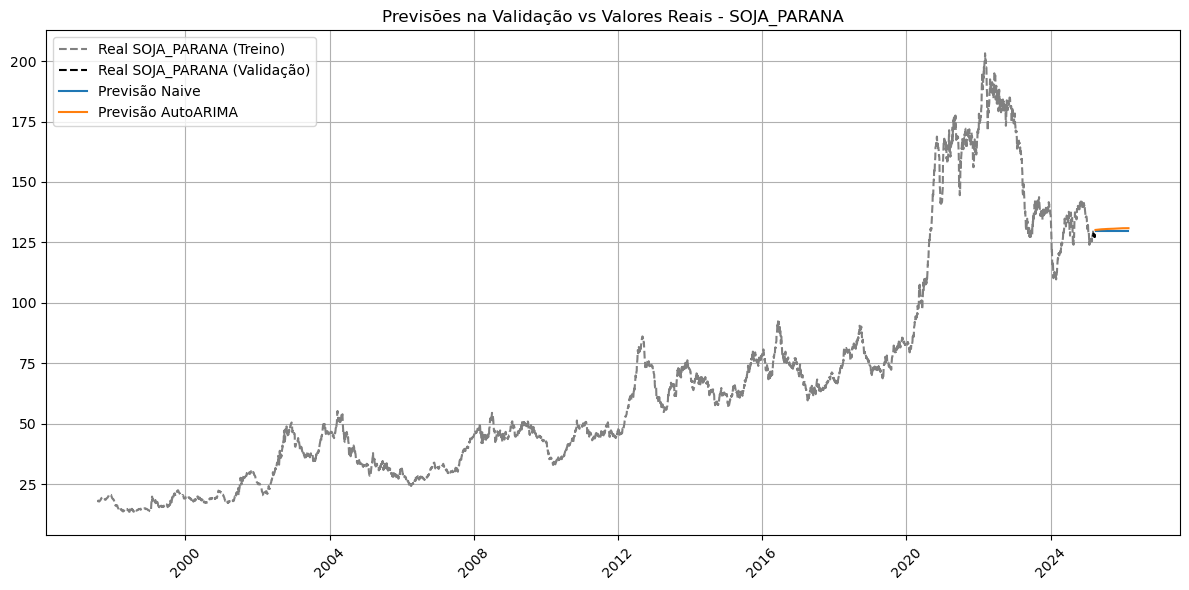

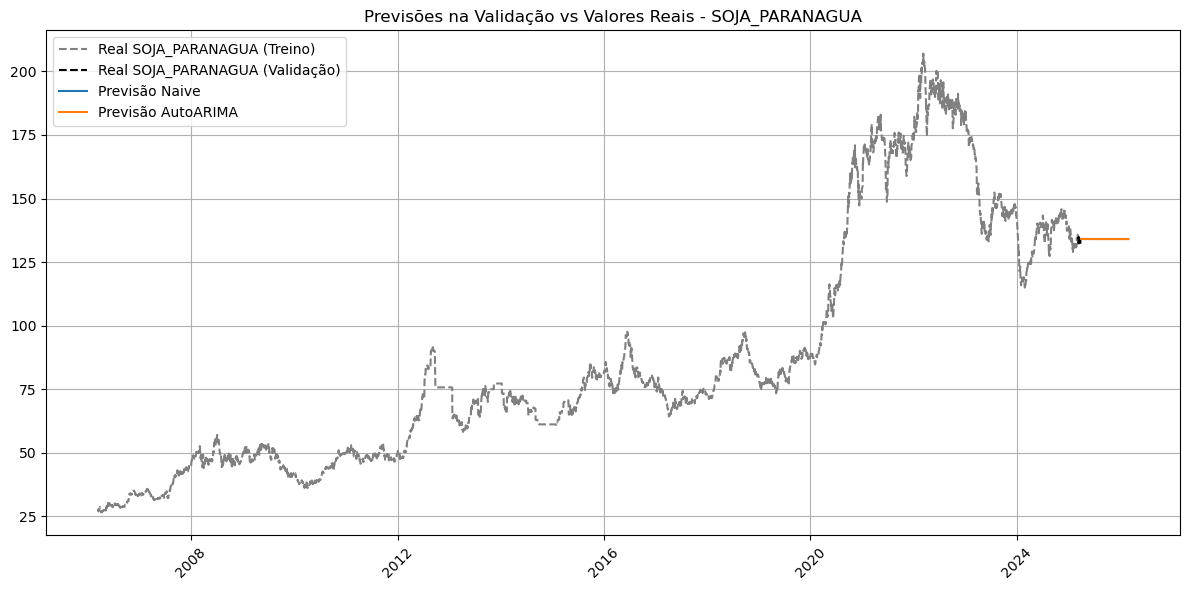

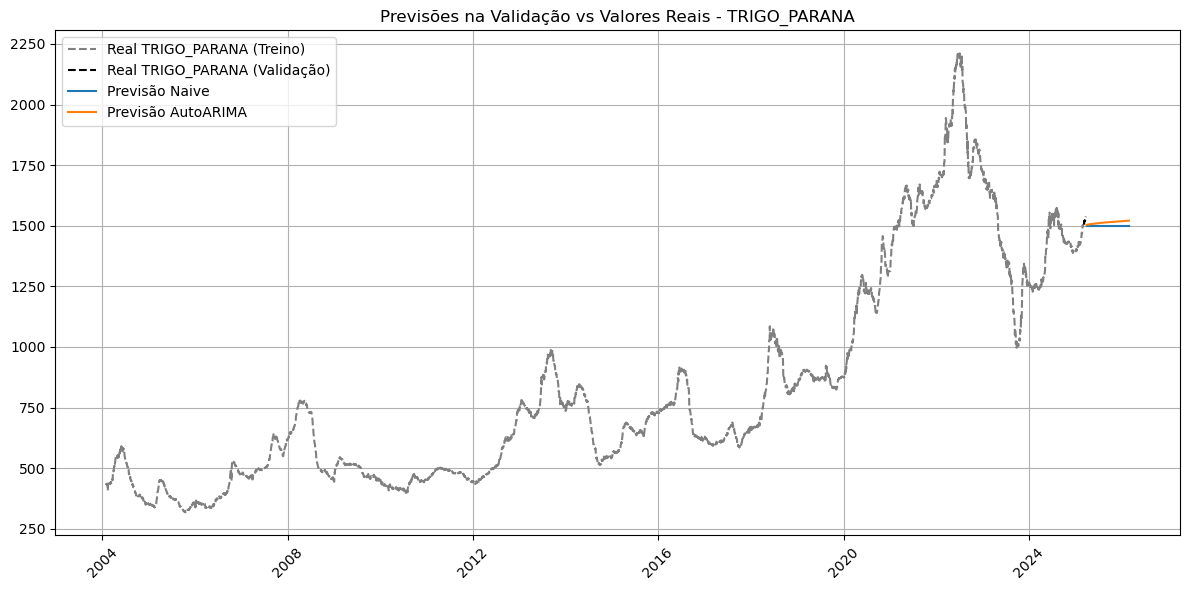

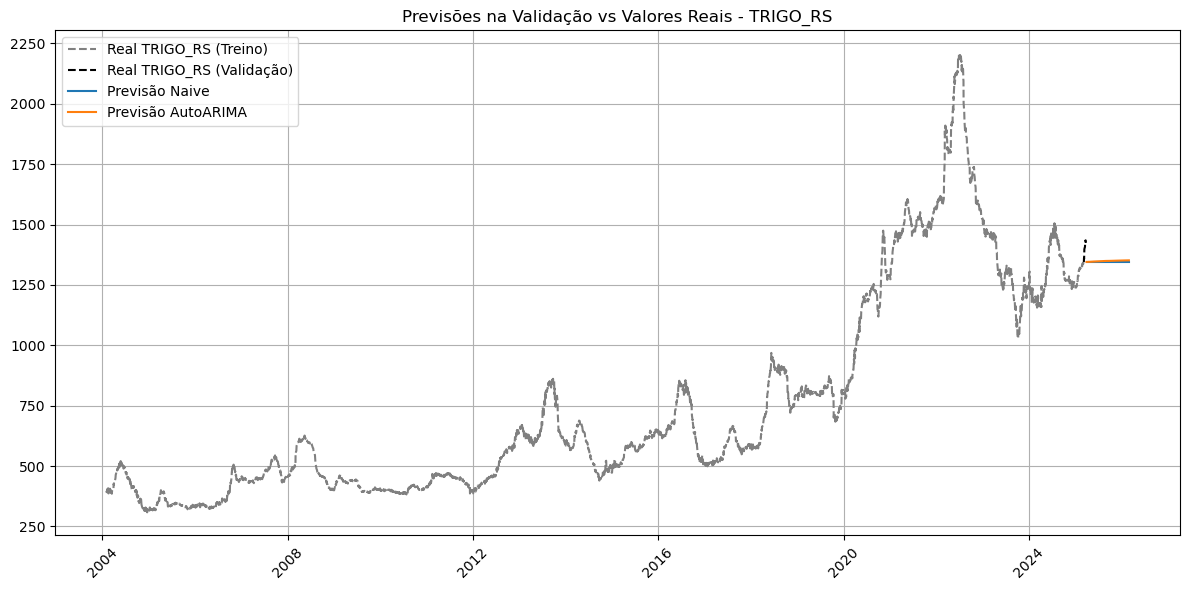

In [19]:
for commodity in X_val_df_brl['unique_id'].unique():
    plot_validation_forecasts(
        train_data=X_train_df_brl,
        val_data=X_val_df_brl,
        forecasts_val=forecasts_val,
        commodity=commodity
    )

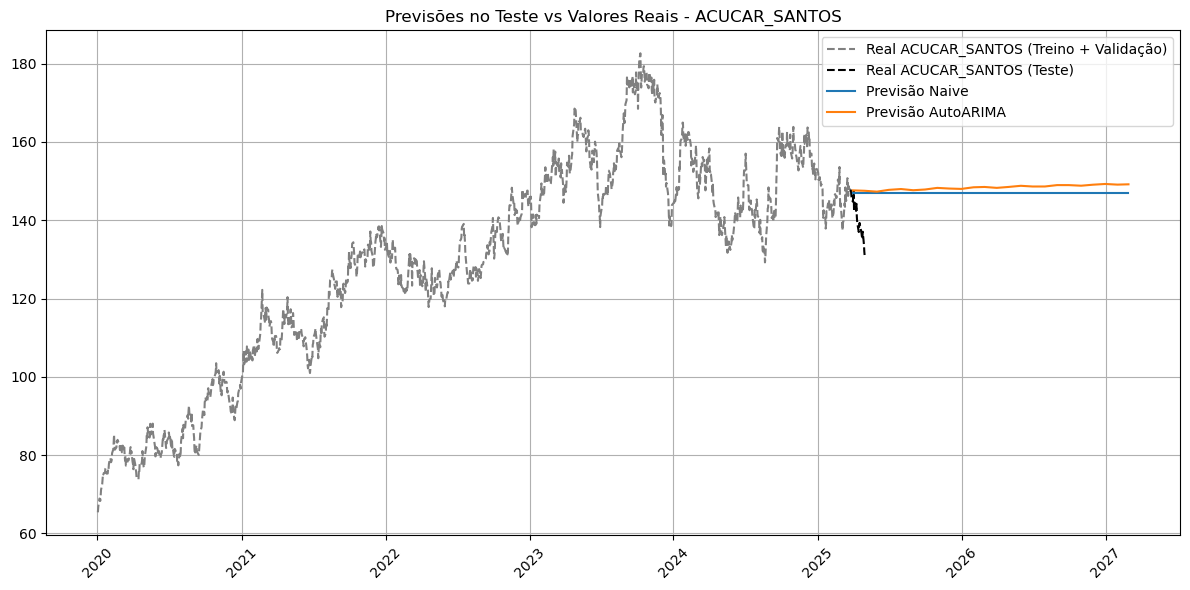

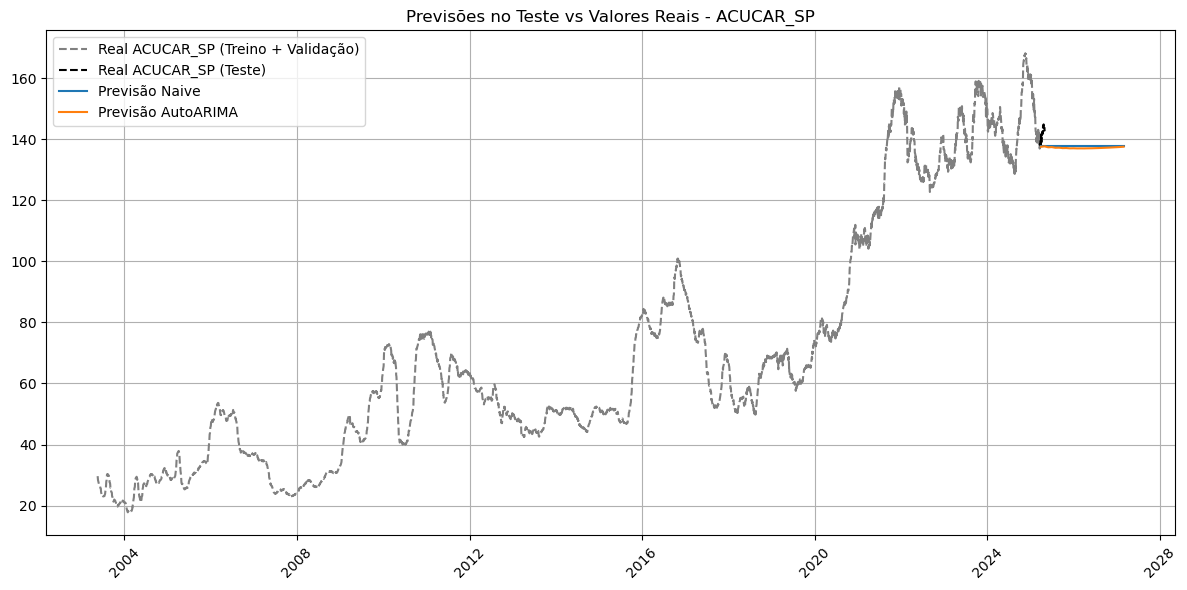

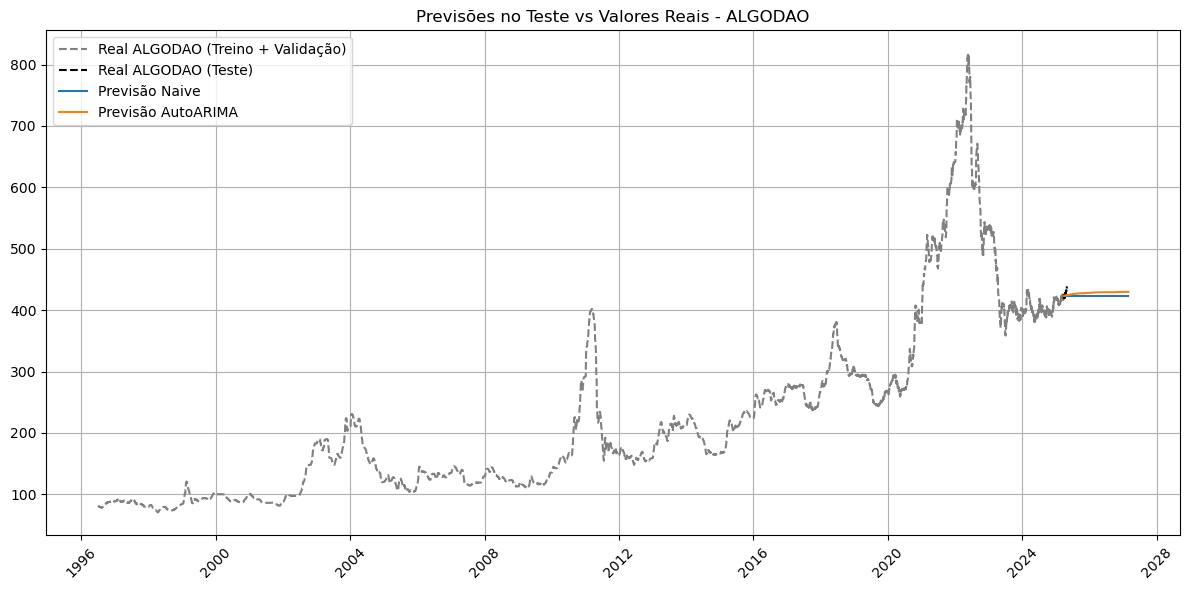

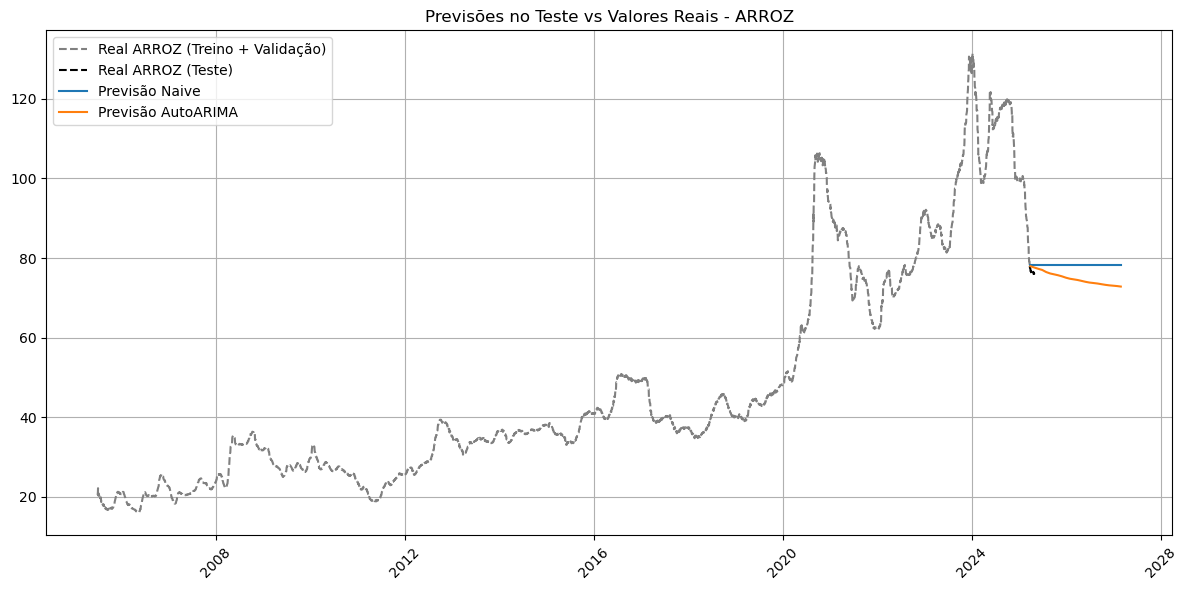

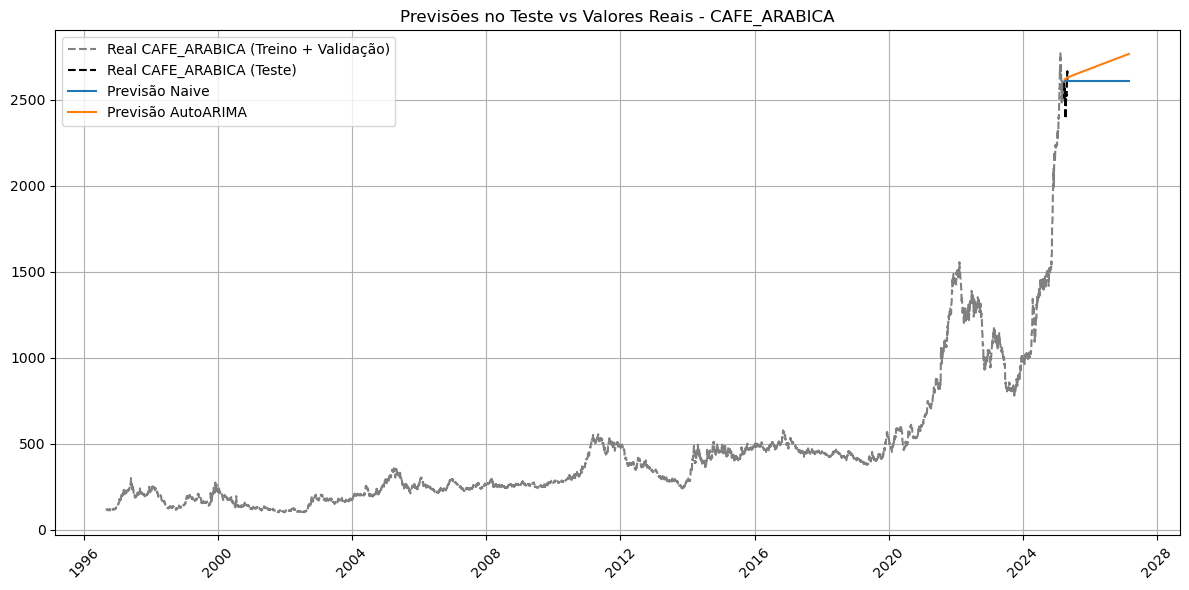

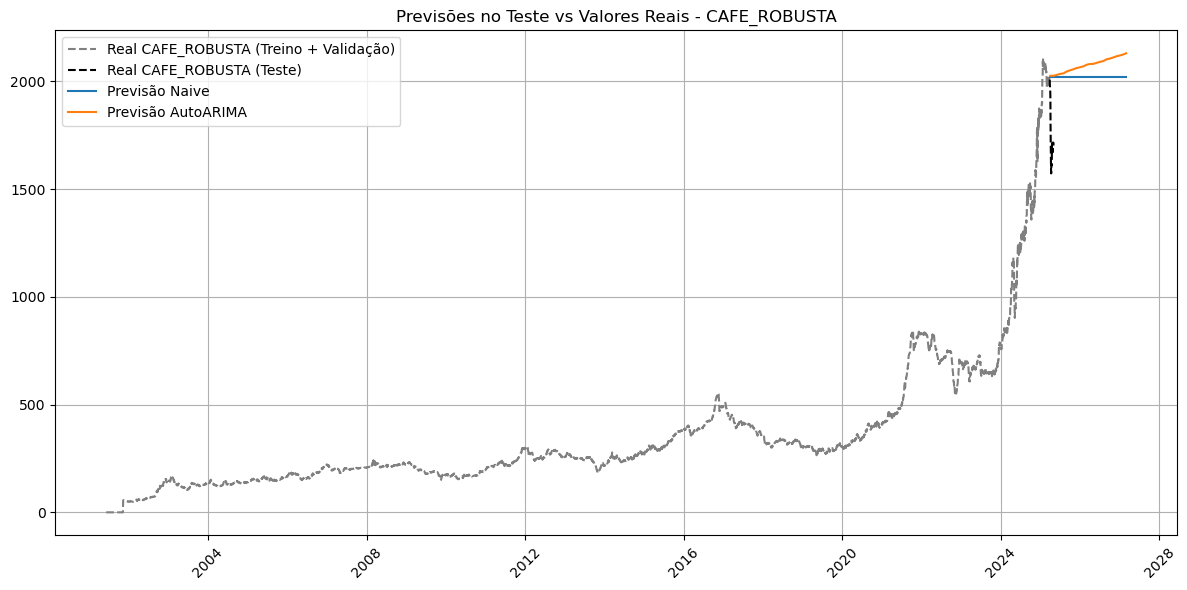

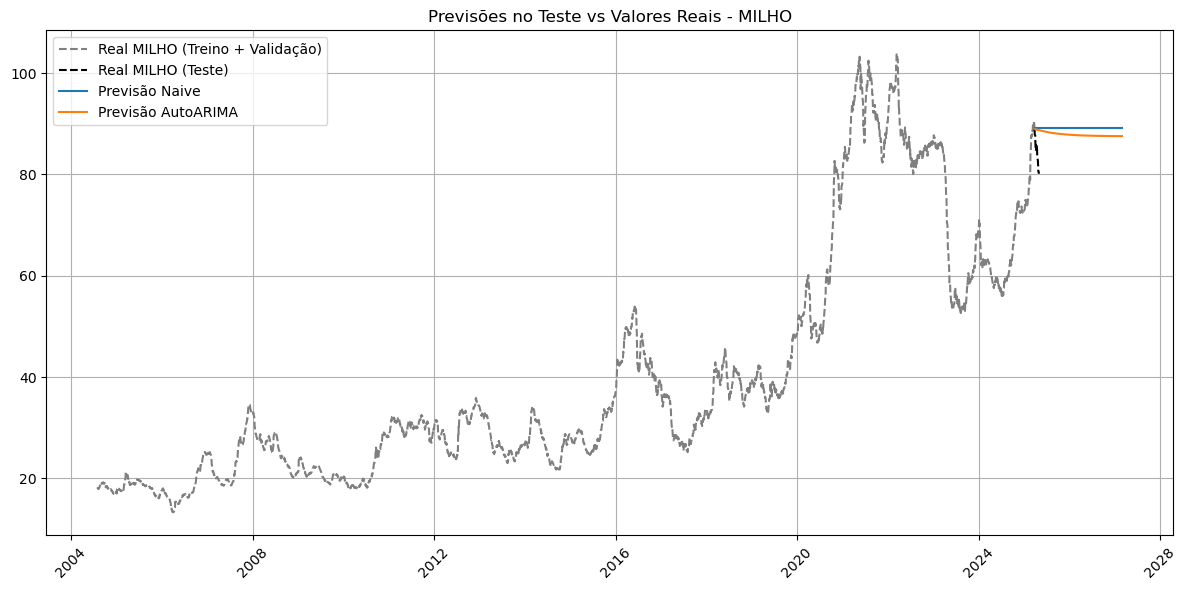

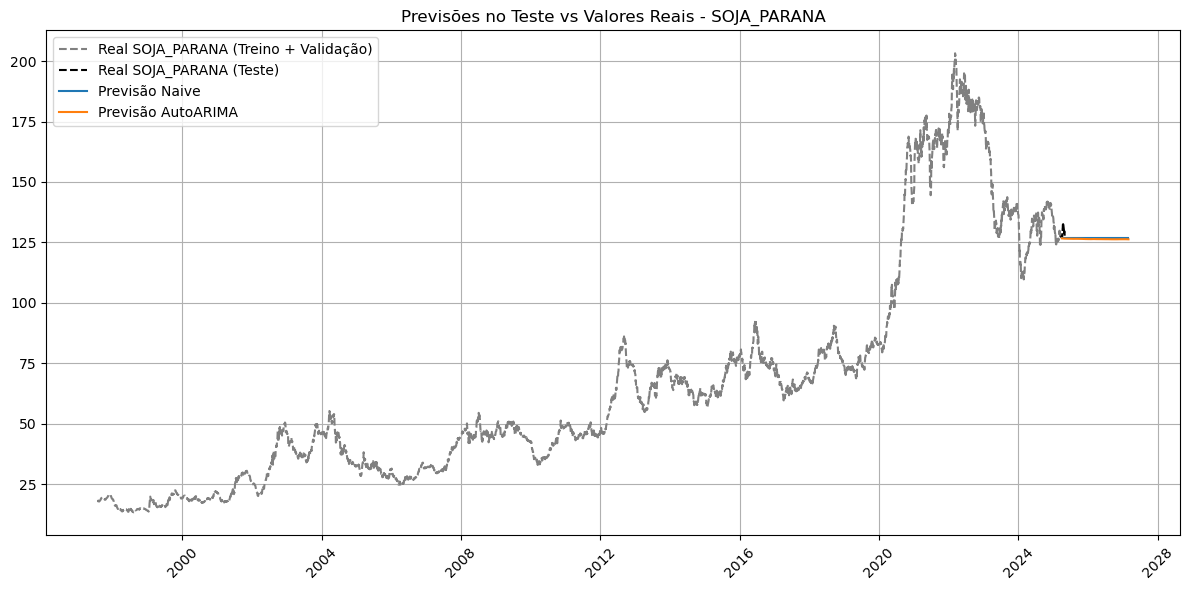

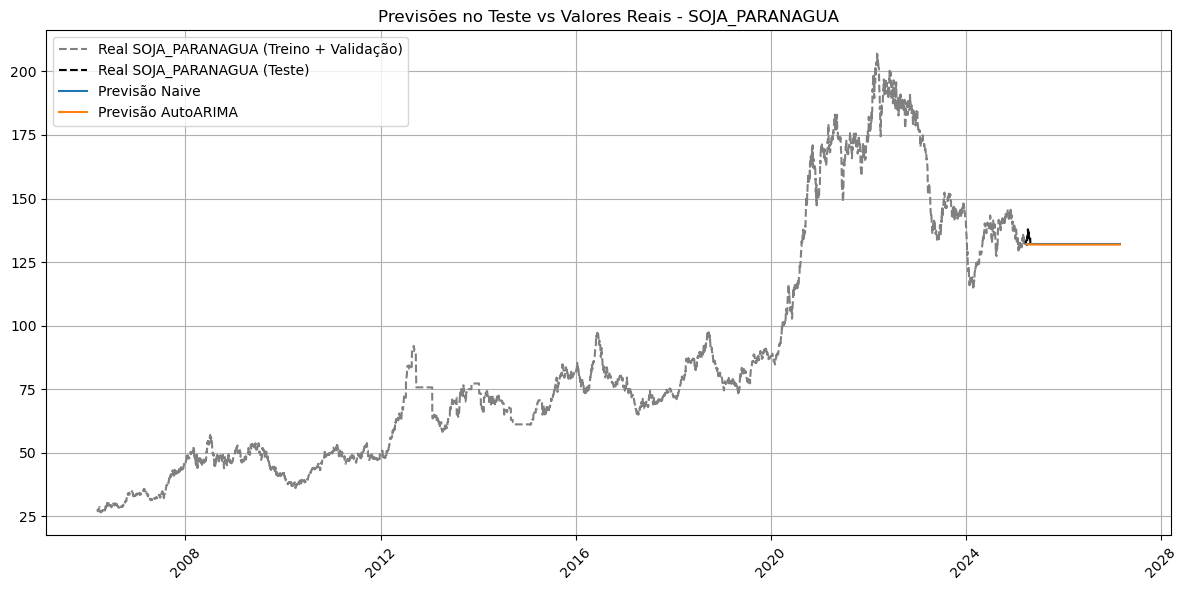

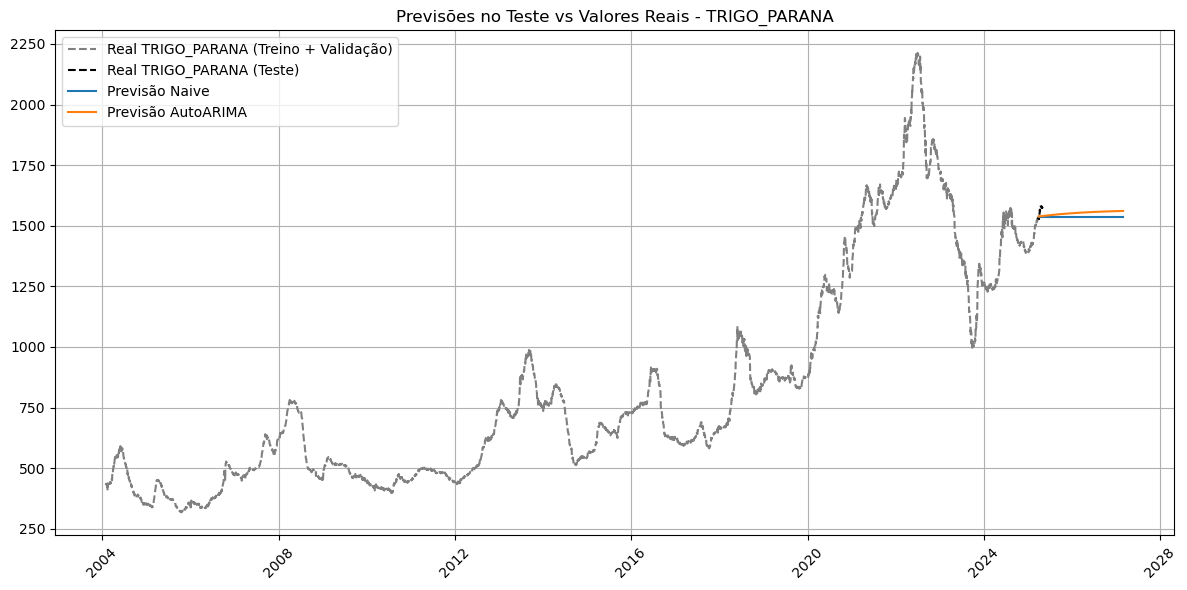

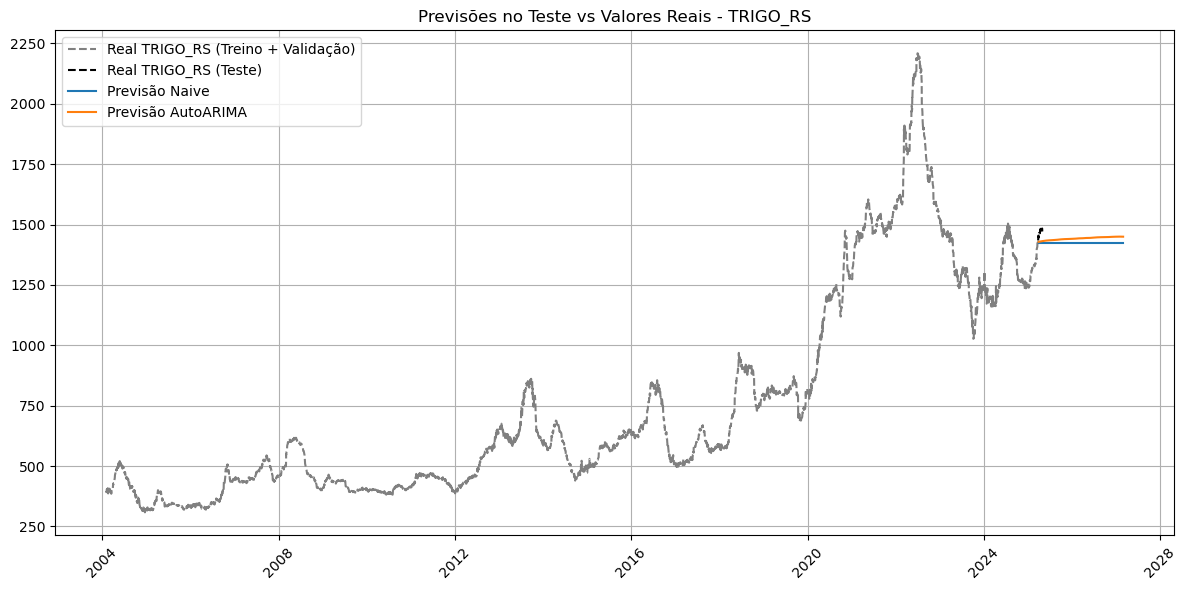

In [20]:
for commodity in Y_test_df_brl['unique_id'].unique():
    plot_test_forecasts(
        full_train=full_train,
        test_data=Y_test_df_brl,
        forecasts_test=forecasts_test,
        commodity=commodity
    )

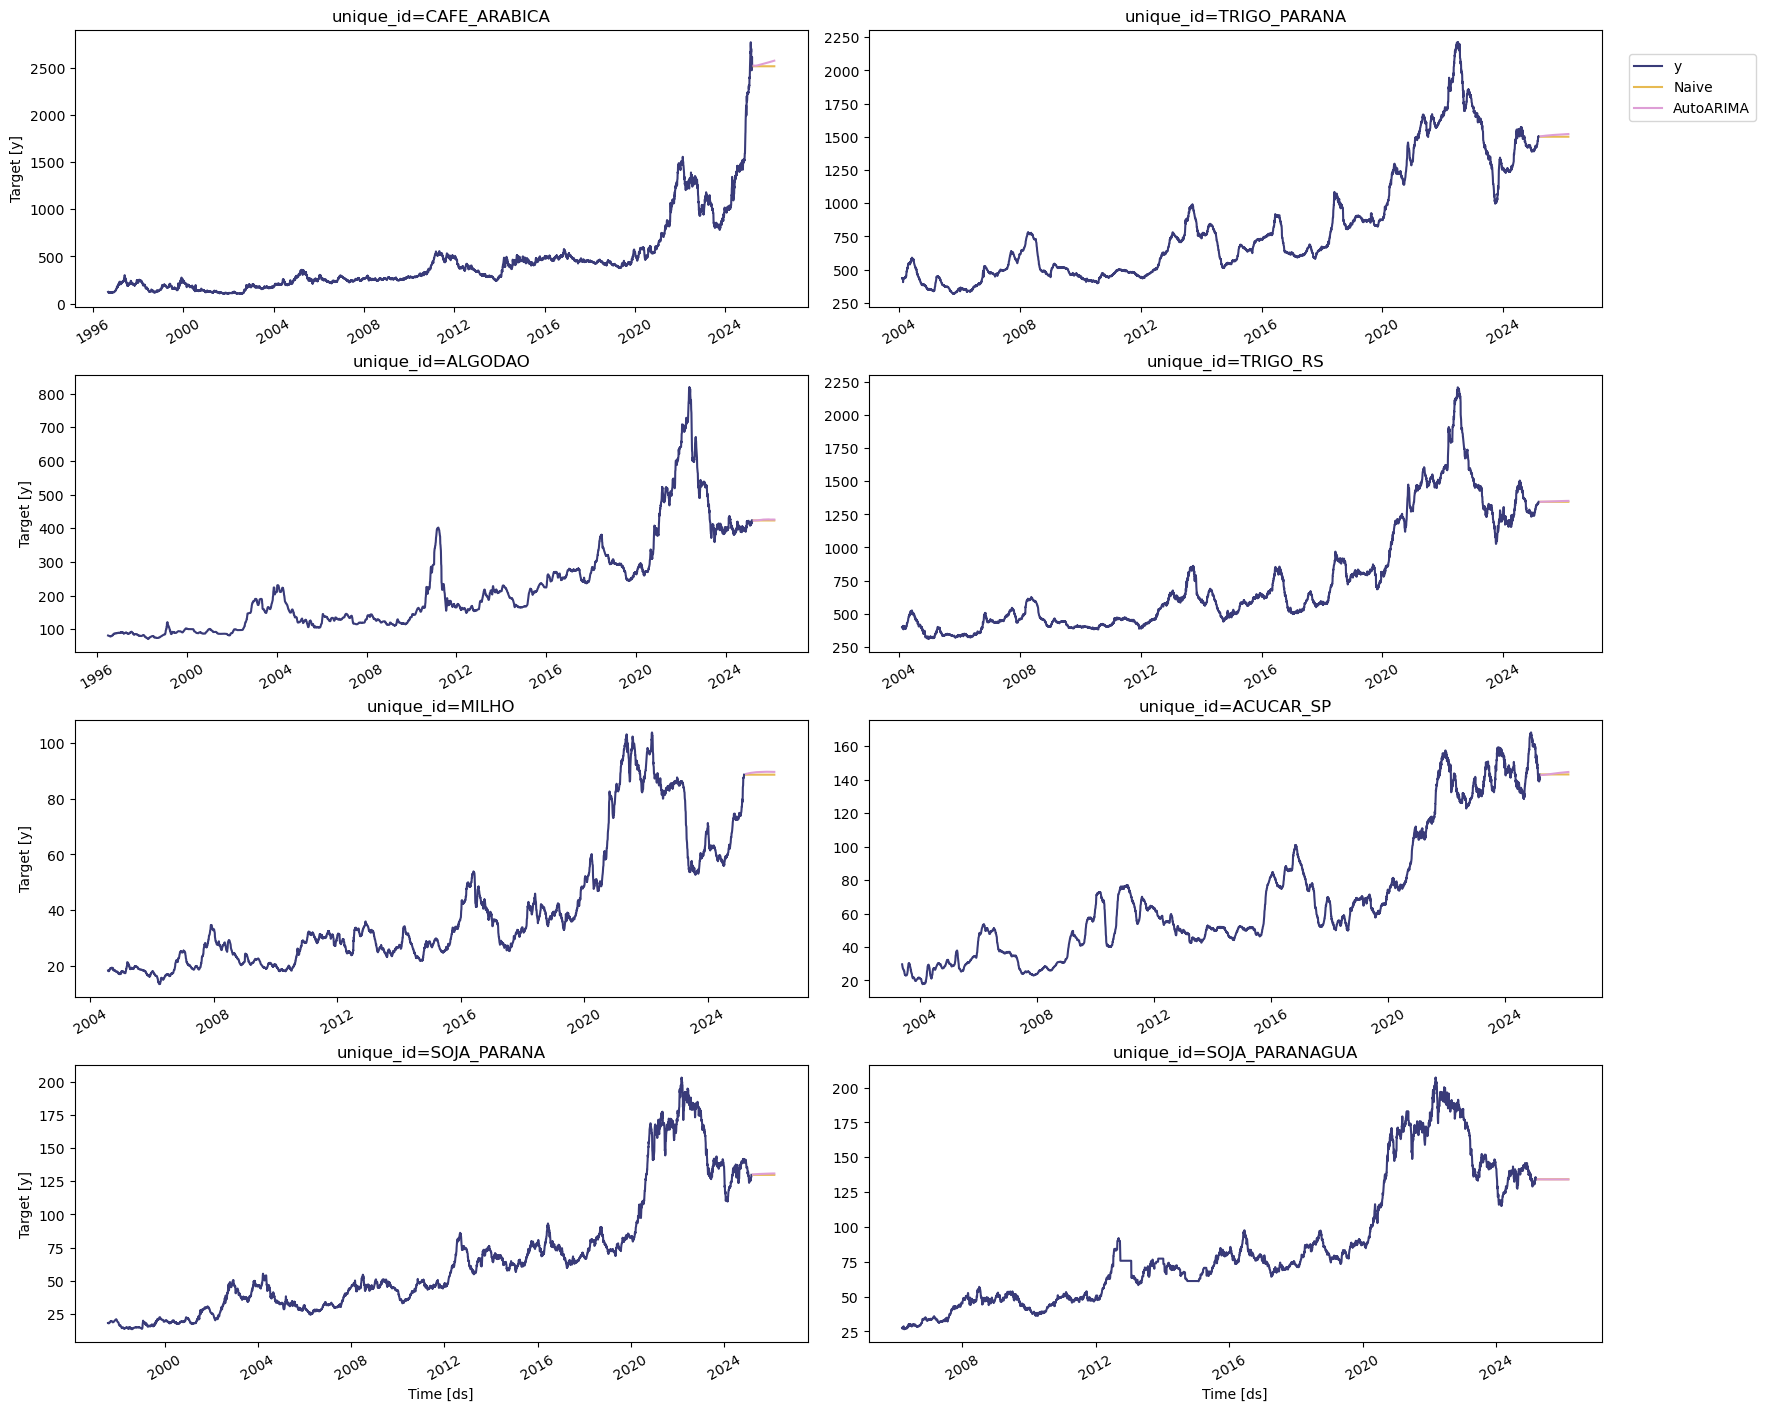

In [21]:
sf.plot(X_train_df_brl,forecasts_val)

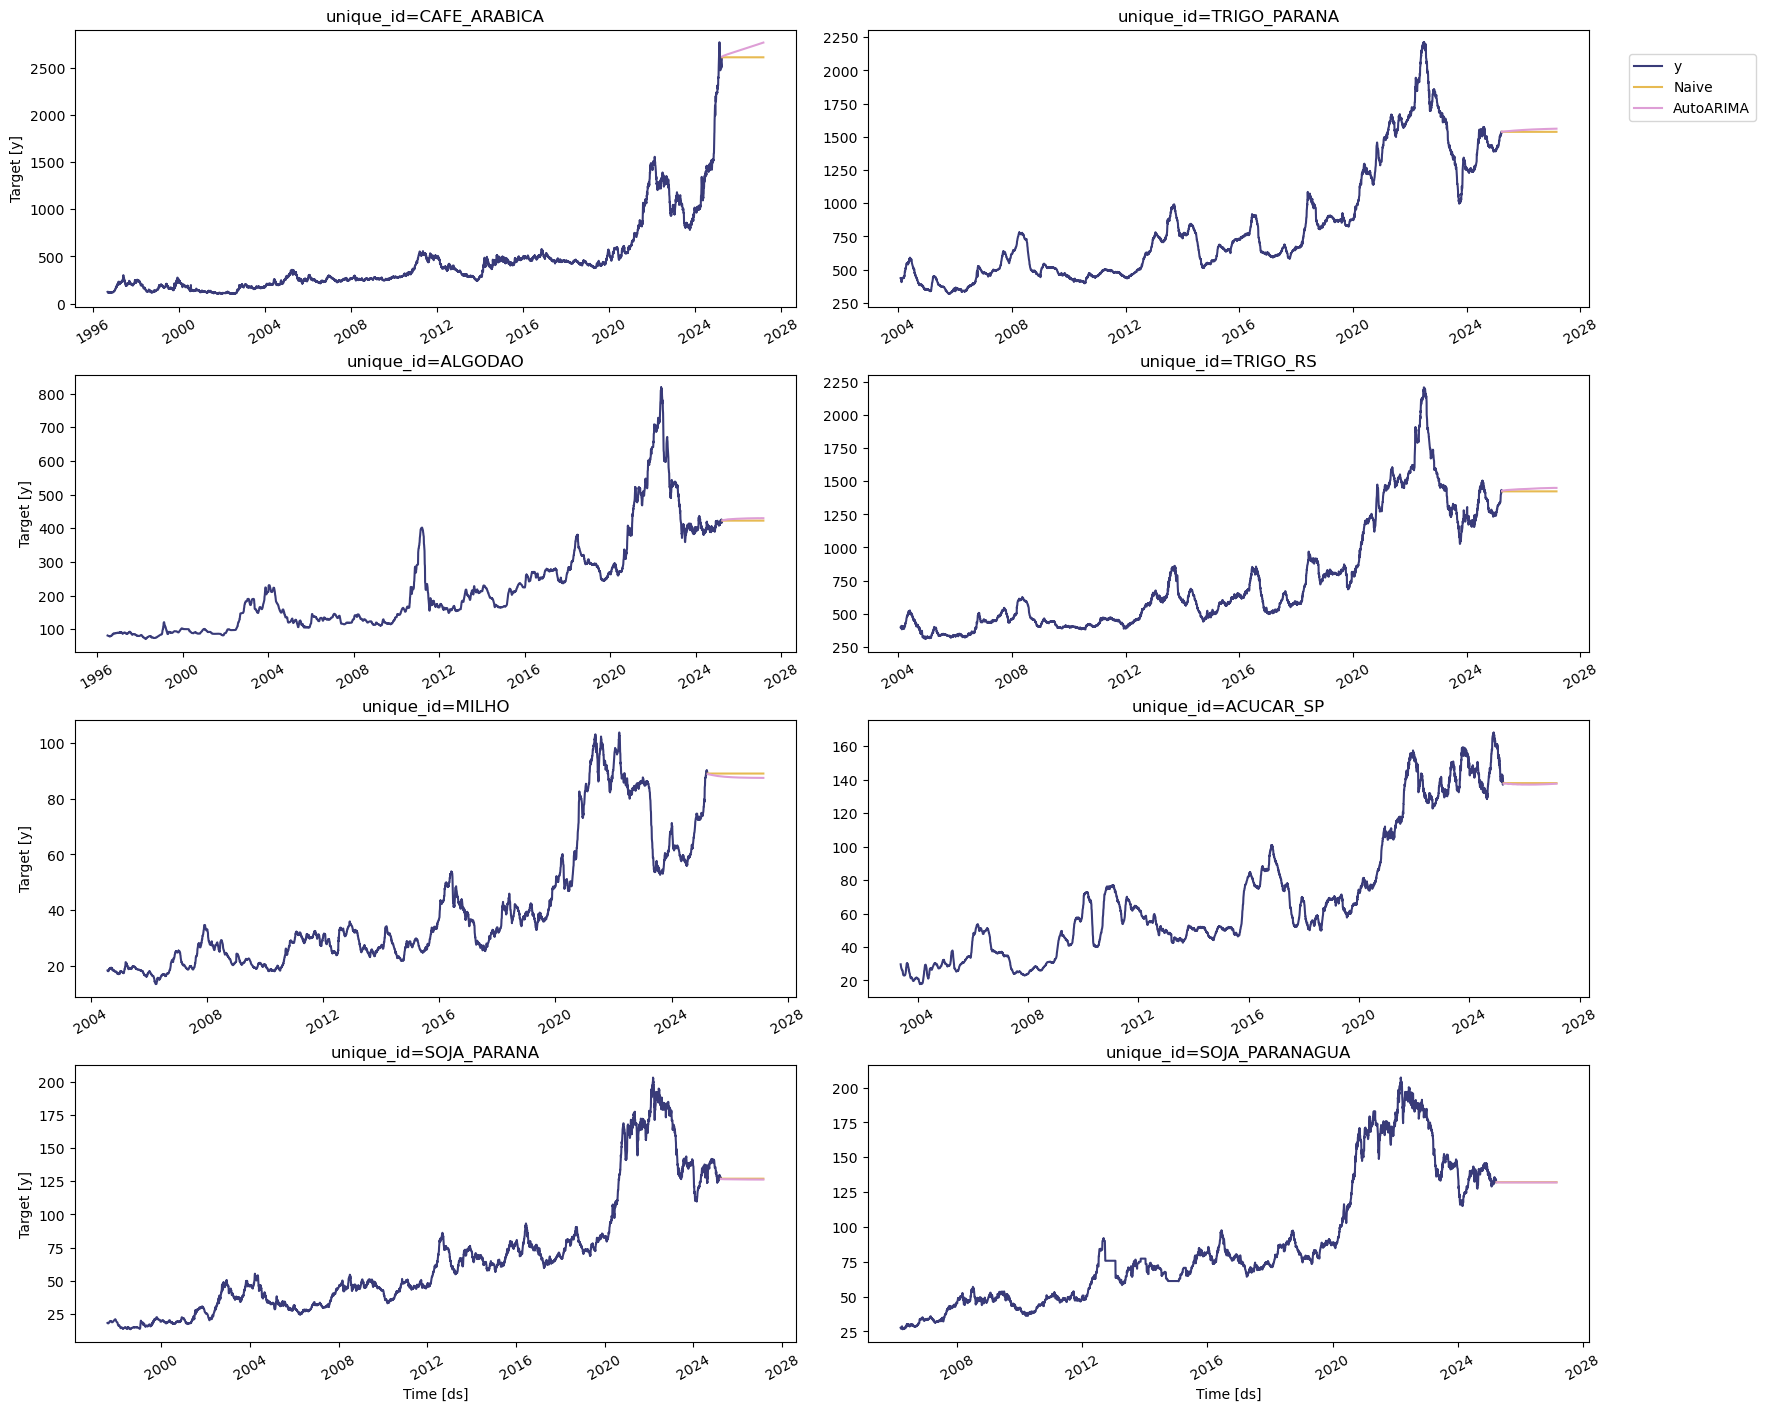

In [22]:
sf.plot(full_train,forecasts_test)

### USD